In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import scipy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

seed_value= 4815
random.seed(seed_value)

In [35]:
PATCH_SIZE = 128
NORM_FACTOR = np.sqrt(PATCH_SIZE**2 + PATCH_SIZE**2)

TEST_PATH = "data/test2014/test2014"
MODEL_PATH = "model/torch_model_2022-12-29_21-01.pth"

# load data and model

In [36]:
input_shape = (128, 128, 2)
kernel_size = 3
pool_size = 2
channels = 64
dropout = 0.5

class homography_net(nn.Module):
    def __init__(self):
        super(homography_net,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(input_shape[2], channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer3 = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(channels, channels ,kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer5 = nn.Sequential(nn.Conv2d(channels, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())        
        self.layer6 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer7 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(128*16*16, 1024)
        self.fc2 = nn.Linear(1024, 8)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.flatten(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [37]:
# load test data
with open(os.path.join(TEST_PATH +"_processed.pickle"), "rb") as f:
    test_data = pickle.load(f)
print(len(test_data))

model = torch.load(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

38842


# network inference

In [38]:
class torch_dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        x = torch.from_numpy((self.data[index][0].astype(float) - 127.5) / 127.5)
        y = torch.from_numpy(self.data[index][1].astype(float).flatten())
        return x, y
    def __len__(self):
        return len(self.data)

test_dataset = torch_dataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, 64)

def test():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.to(device)
            target = target.to(device)
            images = images.permute(0,3,1,2).float()
            target = target.float()
            output = model(images)
            val_loss += F.mse_loss(output, target).item()

    val_loss /= len(test_loader)
    print(f"test MSE: {val_loss}")

test()

test MSE: 0.005974049918135687


In [39]:
def rot_from_mat(mat):
    return np.arctan2(mat[1,0], mat[0,0])

def translation_from_mat(mat):
    return [mat[0][2], mat[1][2]]

def four_point_to_transformation(H_four_point):
    top_left_point  = np.array([-int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])
    bottom_left_point = np.array([-(int(PATCH_SIZE/2)), int(PATCH_SIZE/2)])
    bottom_right_point = np.array([int(PATCH_SIZE/2), int(PATCH_SIZE/2)])
    top_right_point  = np.array([int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])

    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + H_four_point[0], bottom_left_point + H_four_point[1], bottom_right_point + H_four_point[2], top_right_point + H_four_point[3]]))

    translation = translation_from_mat(M)
    rotation = rot_from_mat(M)

    return translation, rotation

# https://github.com/ros/angles/blob/ros2/angles/angles/__init__.py#L42
def normalize_angle(angle):
    a = angle % (2.0*np.pi)
    if a > np.pi:
        a -= 2.0 * np.pi
    return a

In [40]:
top_left_point  = np.array([-int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])
bottom_left_point = np.array([-(int(PATCH_SIZE/2)), int(PATCH_SIZE/2)])
bottom_right_point = np.array([int(PATCH_SIZE/2), int(PATCH_SIZE/2)])
top_right_point  = np.array([int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])

global_gt_rotation, global_rotation_error = [], []

model.eval()
for i in tqdm(range(len(test_data))):
    gt_transformation = four_point_to_transformation(test_data[i][1] * NORM_FACTOR)
    gt_translation = gt_transformation[0]
    gt_rotation = gt_transformation[1]
    global_gt_rotation.append(gt_rotation)

    pair = torch.from_numpy(((test_data[i][0].astype(float) - 127.5) / 127.5).reshape(1, 128, 128, 2))
    pair = pair.to(device)
    pair = pair.permute(0,3,1,2).float()

    prediction = model(pair).cpu().detach().numpy()[0, :] * NORM_FACTOR

    four_points = [np.array([prediction[0], prediction[1]]), np.array([prediction[2], prediction[3]]), np.array([prediction[4], prediction[5]]), np.array([prediction[6], prediction[7]])]
    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + four_points[0], bottom_left_point + four_points[1], bottom_right_point + four_points[2], top_right_point + four_points[3]]))

    rotation_prediction = rot_from_mat(M)
    translation_prediction = translation_from_mat(M)

    global_rotation_error.append(np.degrees(normalize_angle(gt_rotation - rotation_prediction)))*

100%|██████████| 38842/38842 [01:16<00:00, 506.46it/s]


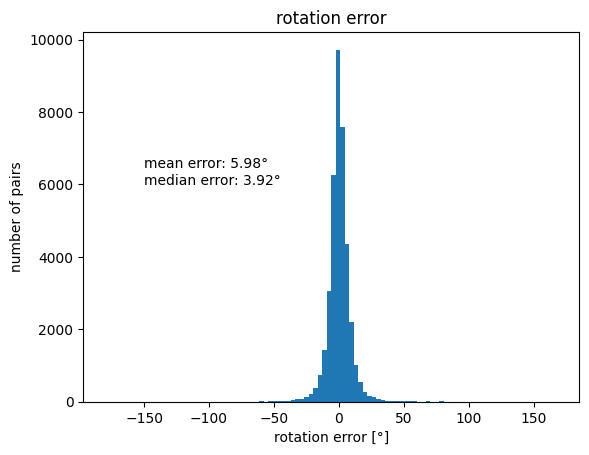

In [41]:
plt.hist(global_rotation_error, bins=100)
plt.title("rotation error")
text = f"mean error: {np.mean(abs(np.array(global_rotation_error))):.2f}°\nmedian error: {np.median(abs(np.array(global_rotation_error))):.2f}°"
plt.text(-150, 6000, s=text)
plt.xlabel("rotation error [°]")
plt.ylabel("number of pairs")
plt.show()

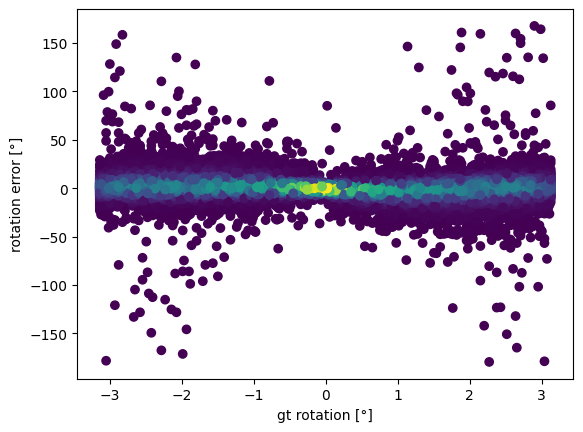

In [42]:
xy = np.vstack([global_gt_rotation, global_rotation_error])
z = scipy.stats.gaussian_kde(xy)(xy)
plt.scatter(global_gt_rotation, global_rotation_error, c=z)

plt.xlabel("gt rotation [°]")
plt.ylabel("rotation error [°]")
plt.show()

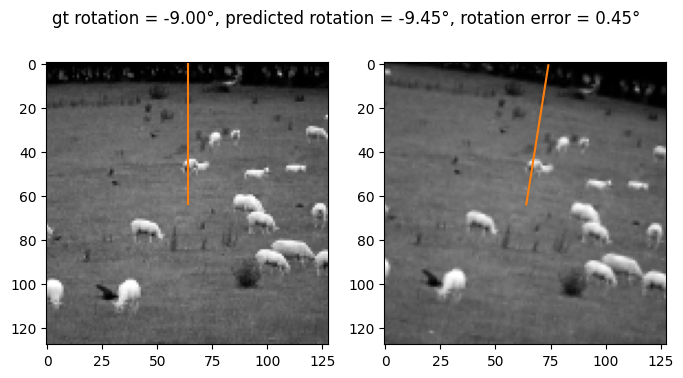

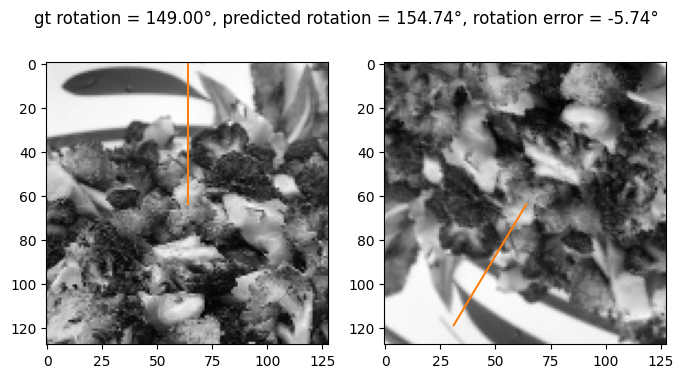

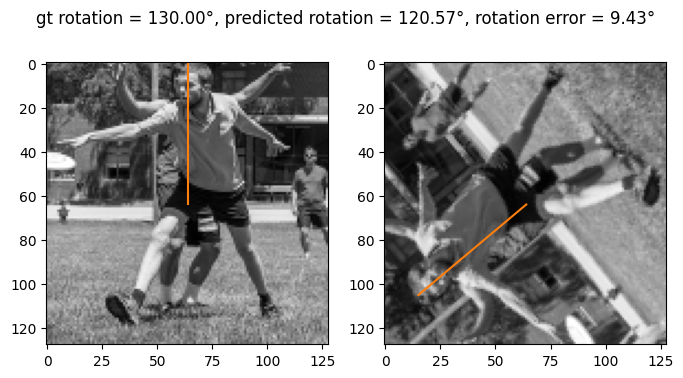

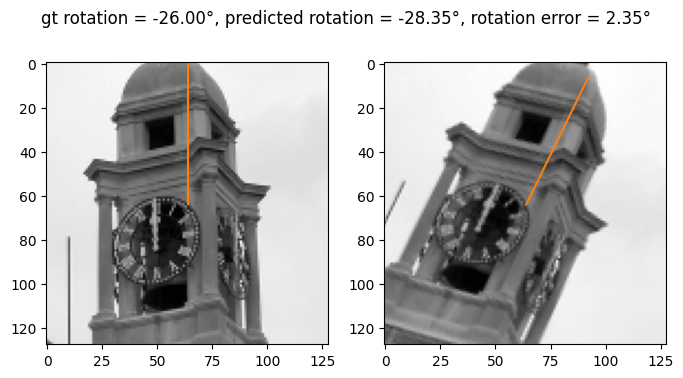

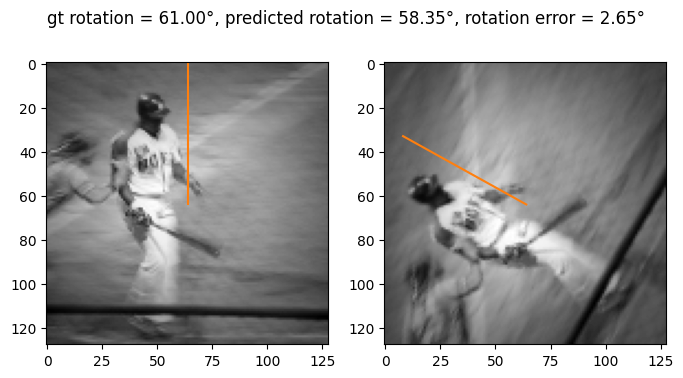

In [43]:
number_of_samples = 5
sample_ids = random.sample(range(len(test_data)), number_of_samples)

model.eval()
for sample in range(len(sample_ids)):
    i = sample_ids[sample]
    gt_transformation = four_point_to_transformation(test_data[i][1] * NORM_FACTOR)
    gt_translation = gt_transformation[0]
    gt_rotation = gt_transformation[1]

    pair = torch.from_numpy(((test_data[i][0].astype(float) - 127.5) / 127.5).reshape(1, 128, 128, 2))
    pair = pair.to(device)
    pair = pair.permute(0,3,1,2).float()

    prediction = model(pair).cpu().detach().numpy()[0, :] * NORM_FACTOR
    four_points = [np.array([prediction[0], prediction[1]]), np.array([prediction[2], prediction[3]]), np.array([prediction[4], prediction[5]]), np.array([prediction[6], prediction[7]])]
    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + four_points[0], bottom_left_point + four_points[1], bottom_right_point + four_points[2], top_right_point + four_points[3]]))
    rotation_prediction = rot_from_mat(M)
    translation_prediction = translation_from_mat(M)

    rotation_error = np.degrees(normalize_angle(gt_rotation - rotation_prediction))

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"gt rotation = {np.degrees(gt_rotation):.2f}°, predicted rotation = {np.degrees(rotation_prediction):.2f}°, rotation error = {rotation_error:.2f}°")
    axs[0].imshow(test_data[i][0][:, :, 0], cmap="gray")
    axs[0].plot([PATCH_SIZE/2, PATCH_SIZE/2], [PATCH_SIZE/2, 0], c="C1")
    axs[1].imshow(test_data[i][0][:, :, 1], cmap="gray")

    # plot orientation line in rotated image
    length = PATCH_SIZE/2
    x = np.cos(-gt_rotation)
    y = np.sin(-gt_rotation)
    if y == 0.0:
        x_scaling = length
        y_scaling = 0
    elif x == 0.0:
        x_scaling = 0
        y_scaling = length
    else:
        x_scaling = (y/x)*length
        y_scaling = (x/y)*length
    x = x * x_scaling
    y = y * y_scaling
    axs[1].plot([PATCH_SIZE/2, PATCH_SIZE/2+x], [PATCH_SIZE/2, PATCH_SIZE/2-y], c="C1")